# SIRD Model

### Set up and Data Processing

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter

In [2]:
# Handle data
# We are given the initial number of dead people, 22
# Assuming that 1% of cases result in death, this gives us an initial removed number of 22*100

who_data = pd.read_csv('cholera_data.csv')

N = 9426017
r_scale = 400.0

I_data = np.array( ( who_data.iloc[:,0]) / N )
R_data = np.array( ( who_data.iloc[:,1]*r_scale ) / N )
D_data = np.array( ( who_data.iloc[:,1]) / N )
S_data = np.array( 1 - I_data - R_data - D_data )

times = who_data.iloc[:,2]

I0 = I_data[0]
R0 = R_data[0]
S0 = S_data[0]
D0 = D_data[0]

### Base Model

In [3]:
def SIRD_model(y,t,alpha,beta, mu, c, h):
    S, I, R, D = y
    dSdt = -(beta)*S*I - c*S*R - h*S*D
    dIdt = (beta)*S*I- alpha*I - mu*I + c*S*R + h*S*D
    dRdt = alpha*I 
    dDdt = mu*I 
    
    return dSdt, dIdt, dRdt, dDdt 

In [4]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
mu = 0.1
h = 0.1
c = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 17
tspan = times[0:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[0:num_days], I_data[0:num_days], R_data[0:num_days], D_data[0:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, mu, c, h = params['alpha'].value, params['beta'].value, params['mu'].value, params['c'].value, params['h'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, mu, c, h)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    return sol_1d - data

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('mu', value=alpha, min=0, max=10)
params.add('c', value=alpha, min=0, max=10)
params.add('h', value=beta, min=0, max=10)

result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

In [5]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
c = result.params['c'].value
mu = result.params['mu'].value
h = result.params['h'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta,"\nc =", c, "\nh =", h, "\nmu =", mu )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta,  mu, c, h)))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
D_model = sol[:,3]

Optimal Parameters: 
alpha = 0.019130547497311357 
beta = 0.043912401396879464 
c = 2.8255175976710234e-13 
h = 1.4346091697925445e-05 
mu = 5.0983086146150214e-05


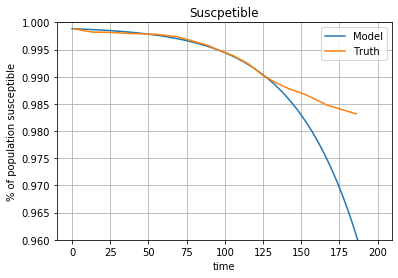

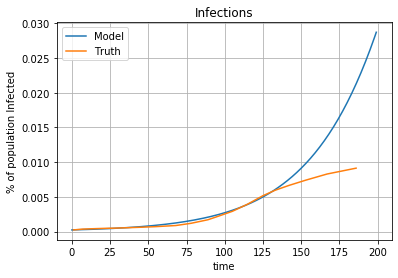

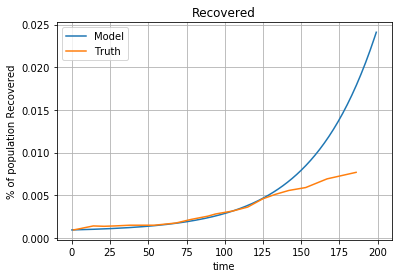

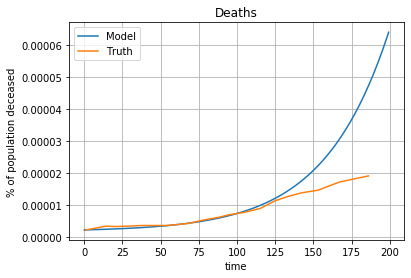

In [9]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:200], S_model[0:200], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.960,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:200], I_model[0:200], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:200], R_model[0:200], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:200], D_model[0:200], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()


### Improved Model

In [66]:
def SIRD_model(y,t,alpha,beta, beta2, mu, c, h, phi):
    S, I, R, D = y
    dSdt = -(beta)*S*I + phi*S*I - c*S*R - h*S*D + beta2*I
    dIdt = (beta)*S*I - phi*S*I - alpha*I - mu*I + c*S*R + h*S*D - beta2*I
    dRdt = alpha*I 
    dDdt = mu*I 
    
    return dSdt, dIdt, dRdt, dDdt 

In [67]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1
beta2 = 0.1
mu = 0.1
h = 0.1
c = 0.1
phi = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, D0]
num_days = 21
tspan = times[0:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[0:num_days], I_data[0:num_days], R_data[0:num_days], D_data[0:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta, beta2, mu, c, h, phi = params['alpha'].value, params['beta'].value, params['beta2'].value, params['mu'].value, params['c'].value, params['h'].value, params['phi'].value
    sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], tspan, args=(alpha, beta, beta2, mu, c, h, phi)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2]),np.array(sol[:,3])))
    return pow(sol_1d - data,2)

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)
params.add('beta2', value=beta, min=0, max=10)
params.add('mu', value=alpha, min=0, max=10)
params.add('c', value=alpha, min=0, max=10)
params.add('h', value=beta, min=0, max=10)
params.add('phi', value=beta, min=0, max=10)

result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

In [68]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value
beta2 = result.params['beta2'].value
c = result.params['c'].value
mu = result.params['mu'].value
h = result.params['h'].value
phi = result.params['phi'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta, "\nbeta2 =", beta2,"\nc =", c, "\nh =", h, "\nmu =", mu, "\nphi =", phi )

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIRD_model, [S0, I0, R0, D0], t, args=(alpha, beta, beta2,  mu, c, h, phi)))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
D_model = sol[:,3]

Optimal Parameters: 
alpha = 0.011681463026821937 
beta = 2.497776286063967 
beta2 = 2.138372987074635 
c = 6.4197186455672295e-09 
h = 0.21428608131145277 
mu = 0.0006420426196390716 
phi = 0.31833433646203


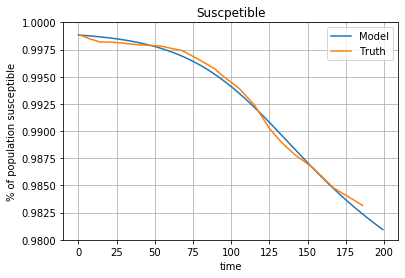

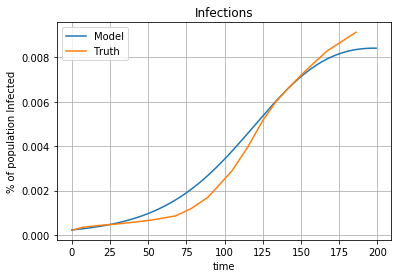

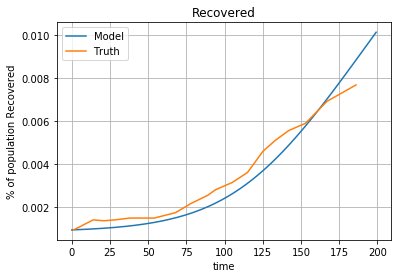

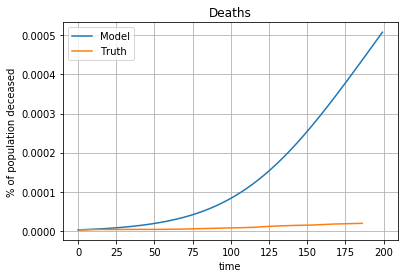

In [69]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:200], S_model[0:200], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.980,1)
plt.show()

# Plot infected
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:200], I_model[0:200], label = "Model")
plt.plot(times, I_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Infected")
plt.title("Infections")
plt.show()
# Plot recovered
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:200], R_model[0:200], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population Recovered")
plt.title("Recovered")
plt.show()

# Plot deceased
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:200], D_model[0:200], label = "Model")
plt.plot(times, D_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population deceased")
plt.title("Deaths")
plt.show()
